# Analyze A/B Test Results 

Table of contents

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


## Part I - Probability

import libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [3]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [4]:
p_convert = (df.converted== 1).mean()
p_convert

0.11965919355605512

**e.** missing values?

In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**f.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
df[((df.group =="treatment") == (df.landing_page == "new_page"))==False ].shape[0]

3893

### 1.1 Data Cleaning
**1.** In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, There are 3893 rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


I decided to delete the rows where the group and landing_page columns don't match.


In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index)

In [10]:
df2 = df2.drop(df2[(df2['group'] == 'control') & (df2['landing_page'] == 'new_page')].index)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The number of unique id in df2

In [12]:
df2['user_id'].nunique()

290584

**2.** check and remove duplicated

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id.. 
df2.drop_duplicates(subset = ['user_id'],inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


### 1.2 Basic insight into probabilities

**a.** The probability of an individual converting regardless of the page they receive?<br><br>




In [14]:
p_population = (df2['converted']==1).mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, the probability they converted?

In [17]:
control_ctr = (df2[df2['group']=='control']['converted']==1).mean()
control_ctr

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_ctr = (df2[df2['group']=='treatment']['converted']==1).mean()
treatment_ctr

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_ctr - control_ctr
obs_diff

-0.0015782389853555567

**c.** The probablity of receiving new page 

In [15]:
prob_new = (df2['landing_page']== 'new_page').mean()
prob_new

0.50006194422266881

**d.** The probability that an individual received the new page?

In [19]:
(df2['landing_page']== 'new_page').mean()

0.50006194422266881

**e.** Initial insight to the convertion 

>**There is no significant difference of convertion rate in the two groups. And we can see that the sample size of both groups are similar. Therefore, It's unlikely that new page/old page would lead to higher convertion rate**

<a id='ab_test'></a>
## Part II - A/B Test
### General Challenges

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- If we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### Null hypothesis and alternative hypothesis 
For now, I would make the decision just based on all the data provided.  


I would assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, My null hypothesis and alternative hypothesis are the below:

<center>
$H_0$ : $p_{new}$ - $p_{old} = 0$
<center>
$H_1$ : $p_{new}$ - $p_{old} >0$

Here for null hypothesis i assumed the convertion rate for people are served with old page **$p_{old}$** and people are served with new page **$p_{new}$** are the same. 

### Methold 1: Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section,I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** the **conversion rate** for $p_{new}$ under the null hypothesis

In [21]:
p_new = (df2['converted']==1).mean()
p_new

0.11959708724499628

**b.** the **conversion rate** for $p_{old}$ under the null hypothesis

In [22]:
p_old = (df2['converted']==1).mean()
p_old

0.11959708724499628

**c.**  $n_{new}$: the number of individuals in the treatment group? <br><br>

In [23]:
n_new = len(df2[df2['group']=='treatment'])
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group

In [24]:
n_old = len(df2[df2['group']=='control'])
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [37]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],145310,p = [1-p_new,p_new])

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [38]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],145274,p = [1-p_old,p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [39]:
p_new_sample = new_page_converted.mean()
p_old_sample = old_page_converted.mean()
p_diff = p_new_sample - p_old_sample
p_diff

-0.0024107760623885005


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [40]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [41]:
p_diffs

array([ 0.00041071,  0.00085795, -0.00170209, ...,  0.00057606,
       -0.00098615,  0.00174653])

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

Text(0,0.5,'frequency')

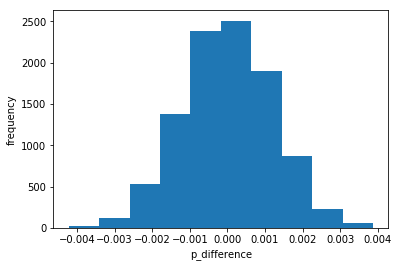

In [42]:
plt.hist(p_diffs)
plt.xlabel("p_difference")
plt.ylabel("frequency")

**j.** The proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data

In [43]:
(p_diffs > obs_diff).mean()

0.90469999999999995

**k. Hypothesis test summary** <br>
 

>*** In section j we calculated p-value,which is the probability of obtaining test results at least as extreme as the result actually observed,Here we can see the p value is around 0.9. It's greater than the type I error. Therefore, we can't reject null hypothesis that convertion rates are the same for the group served with new page and the group served with old page***



**Method 2 . Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results. 
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [36]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = (df2[df2['group']=='control']['converted']).sum()

# number of conversions with the new_page
convert_new = (df2[df2['group']=='treatment']['converted']==1).sum()

# number of individuals who were shown the old_page
n_old = len(df2[df2['group'] =='control'])

# number of individuals who received new_page
n_new = len(df2[df2['group'] =='treatment'])


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 






In [47]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** summary based on z value

> The z-score of 1.31 does not exceed the critical value of 1.645 therefore,we don't have enough evidences to reject the null hypothesis. The result agreed with the finding in part j and k 

<a id='regression'></a>
### Part III - A regression approach

### a.  logistic regression to perform A/B testing

>since the predicted responses are either converted or not converted. Logistic regression suits this case

**b.** use **statsmodels** library to fit the regression model I specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. following columns needed to be created
 1. `intercept` - It should be `1` in the entire column. 
 2. `treatment` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [46]:
df3 = df2 
df3['intercept'] = 1
df3[['ab_page','treatment']] = pd.get_dummies(df3['group'])
df3.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate the regression model on the two columns created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [47]:
log_mod = sm.Logit(df3['converted'],df3[['intercept','treatment']])
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-29 11:47 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [51]:
 1/np.exp(-0.0160)

1.0161286854060947

**e.logistic model summary**


The null hypotheses associated with the regression model is the convertion rate for people served with old page. we expoential the coefficient for treatment group, we can see that the individual who are showed with the new_page is 1.5% more likely to convert than the individual who showed with the old page,which doesn't look significant.

meantime, the p value is 0.1899 which is greater than the type I error rate(0.05),which tells us that the landing page is not statistically significant in predicting whether the viewer converts or not.

The big difference is, this is a two-tailed test and in Part II was one tailed test.
**

**f. other factors might influence the convertion rate** 

There are other things that might affect if an individual is converted or not, so that the website can know better about their targeted customer. for example, age, income level,time spent on the website etc. However,There are also disadvantages of using too many factors:

- A linear relationship doesn't exist
- Correlated errors
- Non-constant variance
- outliers
- Multicollinearity 



**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 



In [49]:
# Read the countries.csv
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
# Join with the df2 dataframe
df_merged = df3.merge(country,how = 'inner',on = 'user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [55]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged.head(30)
log_mod_2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'treatment', 'CA','UK']])
result_country = log_mod_2.fit()
result_country.summary2()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-27 16:21 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

Given the p-value here are all bigger than 0.05, There is not significant relationship between country and convertion rate

**h. Fit your model and obtain the results**<br> 
Though we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  


In [59]:
# Fit your model, and summarize the results
df_merged['CA_new'] = df_merged['treatment']*df_merged['CA']
df_merged['UK_new'] = df_merged['treatment']*df_merged['UK']
df_merged['US_new'] = df_merged['treatment']*df_merged['US']
log_mod_inter = sm.Logit(df_merged['converted'], df_merged[['intercept', 'treatment', 'CA','UK','CA_new','UK_new']])
result_inter = log_mod_inter.fit()
result_inter.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-27 16:23 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
treatment    -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**The results shows the interaction between page and country has no impact on the conversion rate because all of the p-values are still larger than our type 1 error rate of 0.05. It doesn't affect our conversion rate. Therefore we don't have enough evident to reject null hypothesis that the convertion rate for old page is the same as the convertion rate for new page**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])